In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings


In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
DATASET_NAME = 'cstr2'
WINDOW_SIZE = 10

In [4]:
# exclude_columns = ['Fault']

In [5]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=WINDOW_SIZE, noise_scale=0.0, use_classes=list(range(0,10)))

In [21]:
# print(timeseries)
# print(labels.head)
print(test_timeseries)
# print(labels['label'])

                     Caf        h     Qf        Ca           T   Tf  \
node_id   timestamp                                                   
node_1_10 1            1  5.99995  100.0  0.037237  402.352313  320   
          2            1  5.99995  100.0  0.037235  402.352942  320   
          3            1  5.99995  100.0  0.037232  402.353571  320   
          4            1  5.99995  100.0  0.037228  402.354565  320   
          5            1  5.99995  100.0  0.037222  402.356208  320   
...                  ...      ...    ...       ...         ...  ...   
node_9_99 95           1  5.99995  100.0  0.052743  395.721775  320   
          96           1  5.99995  100.0  0.052755  395.720748  320   
          97           1  5.99995  100.0  0.052765  395.716783  320   
          98           1  5.99995  100.0  0.052778  395.710543  320   
          99           1  5.99995  100.0  0.052756  395.718207  320   

                             Tc     Qc    Tcf      Q  
node_id   timestamp  

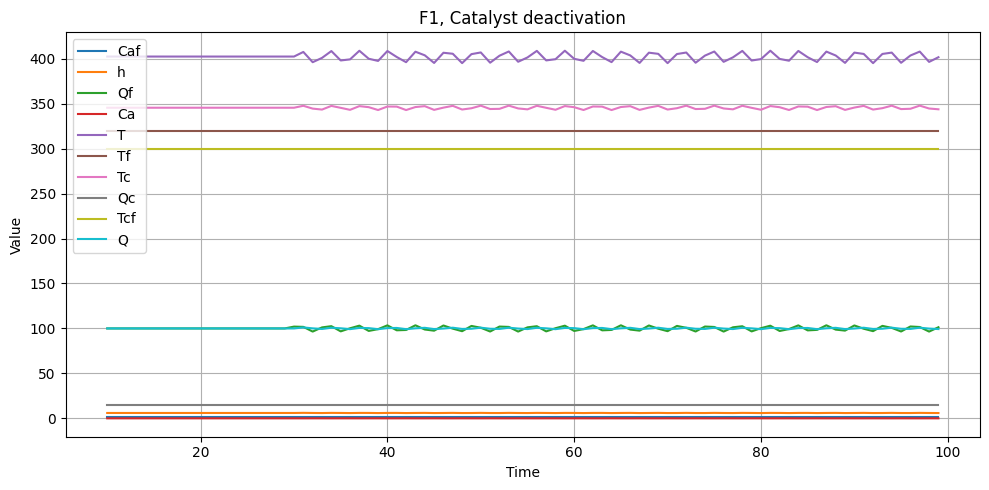

In [22]:
comparison_df=pd.DataFrame(test_timeseries)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,2):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    # columns_to_plot = ['Ca']
    # single_node_df_filtered = single_node_df[columns_to_plot]    

    # scaler = MinMaxScaler()
    # single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    # plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()


In [23]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100))
], verbose=True)

In [25]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


[Pipeline] .......... (step 2 of 5) Processing features, total=   4.4s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier())],
         verbose=True)

In [27]:
test_timeseries

Caf        h     Qf        Ca           T   Tf  \
node_id   timestamp                                                   
node_1_10 1            1  5.99995  100.0  0.037237  402.352313  320   
          2            1  5.99995  100.0  0.037235  402.352942  320   
          3            1  5.99995  100.0  0.037232  402.353571  320   
          4            1  5.99995  100.0  0.037228  402.354565  320   
          5            1  5.99995  100.0  0.037222  402.356208  320   
...                  ...      ...    ...       ...         ...  ...   
node_9_99 95           1  5.99995  100.0  0.052743  395.721775  320   
          96           1  5.99995  100.0  0.052755  395.720748  320   
          97           1  5.99995  100.0  0.052765  395.716783  320   
          98           1  5.99995  100.0  0.052778  395.710543  320   
          99           1  5.99995  100.0  0.052756  395.718207  320   

                             Tc     Qc    Tcf      Q  
node_id   timestamp                                   
node_1_10 1          345.438559  15.00  300.0  100.0  
          2          345.438488  15.00  300.0  100.0  
          3          345.438419  15.00  300.0  100.0  
          4          345.438308  15.00  300.0  100.0  
          5          345.438122  15.00  300.0  100.0  
...                         ...    ...    ...    ...  
node_9_99 95         337.186509  18.85  300.0  100.0  
          96         337.185401  18.85  300.0  100.0  
          97         337.186580  18.85  300.0  100.0  
          98         337.188757  18.85  300.0  100.0  
          99         337.186947  18.85  300.0  100.0  

[8100 rows x 10 columns]

In [28]:
preds = pipeline.predict(test_timeseries)

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


In [29]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.8628184518549686
0 0.8181818181818182
1 1.0
2 0.9465648854961832
3 0.9777777777777777
4 0.9927007299270073
5 1.0
6 0.9852941176470589
7 1.0
8 0.9852941176470589
9 0.0


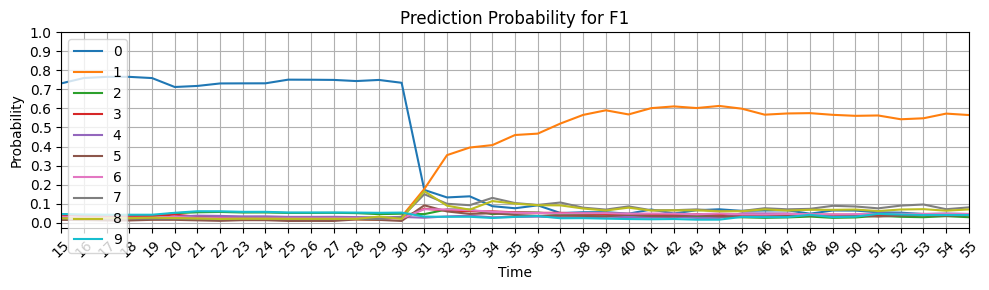

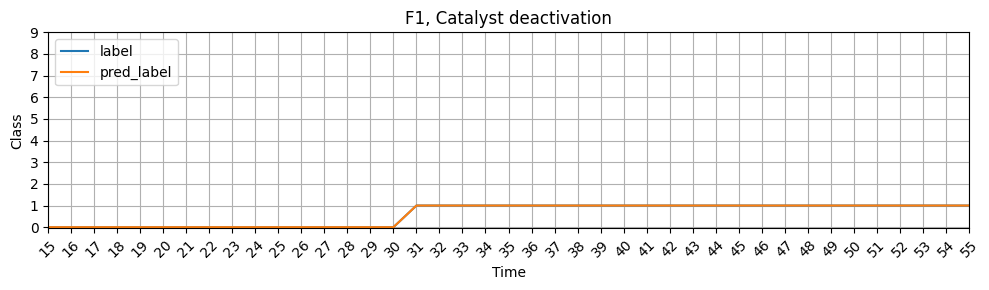

In [30]:
comparison_df=pd.DataFrame(test_labels)
comparison_df['pred_label'] = preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,2):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,100):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(test_timeseries.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,100))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for F{}".format(i))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 3))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 10, step=1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [31]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [32]:
# test_labels['label']

In [33]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 1 #UPDATE HERE FOR OTHER CLASSES
pred_select = 1 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_1_31', 21], ['node_1_32', 22], ['node_1_33', 23], ['node_1_34', 24], ['node_1_35', 25], ['node_1_36', 26], ['node_1_37', 27], ['node_1_38', 28], ['node_1_39', 29], ['node_1_40', 30], ['node_1_41', 31], ['node_1_42', 32], ['node_1_43', 33], ['node_1_44', 34], ['node_1_45', 35], ['node_1_46', 36], ['node_1_47', 37], ['node_1_48', 38], ['node_1_49', 39], ['node_1_50', 40], ['node_1_51', 41], ['node_1_52', 42], ['node_1_53', 43], ['node_1_54', 44], ['node_1_55', 45], ['node_1_56', 46], ['node_1_57', 47], ['node_1_58', 48], ['node_1_59', 49], ['node_1_60', 50], ['node_1_61', 51], ['node_1_62', 52], ['node_1_63', 53], ['node_1_64', 54], ['node_1_65', 55], ['node_1_66', 56], ['node_1_67', 57], ['node_1_68', 58], ['node_1_69', 59], ['node_1_70', 60], ['node_1_71', 61], ['node_1_72', 62], ['node_1_73', 63], ['node_1_74', 64], ['node_1_75', 65], ['node_1_76', 66], ['node_1_77', 67], ['node_1_78', 68], ['node_1_79', 69], ['node_1_80', 70], ['node_1_81', 71], ['node_1_82', 72], ['node_1_83

In [34]:
timeseries.loc[['node_101_32'], :, :]

Caf        h     Qf        Ca           T   Tf  \
node_id     timestamp                                                   
node_101_32 23           1  5.99995  100.0  0.037240  402.351506  320   
            24           1  5.99995  100.0  0.037240  402.351661  320   
            25           1  5.99995  100.0  0.037239  402.351893  320   
            26           1  5.99995  100.0  0.037237  402.352259  320   
            27           1  5.99995  100.0  0.037235  402.352887  320   
            28           1  5.99995  100.0  0.037233  402.353472  320   
            29           1  5.99995  100.0  0.037229  402.354374  320   
            30           1  5.99995  100.0  0.037223  402.355926  320   
            31           1  5.99995  100.0  0.037240  402.351618  320   
            32           1  5.99995  100.0  0.037239  402.351817  320   

                               Tc    Qc    Tcf      Q  
node_id     timestamp                                  
node_101_32 23         345.438649  15.0  300.0  100.0  
            24         345.438632  15.0  300.0  100.0  
            25         345.438606  15.0  300.0  100.0  
            26         345.438565  15.0  300.0  100.0  
            27         345.438494  15.0  300.0  100.0  
            28         345.438430  15.0  300.0  100.0  
            29         345.438329  15.0  300.0  100.0  
            30         345.438154  15.0  300.0  100.0  
            31         345.438636  15.0  300.0  100.0  
            32         345.438614  15.0  300.0  100.0

2024-03-11 18:56:36,399 INFO    Working on turning label from 1 to 0
2024-03-11 18:56:36,402 INFO    Min dist:5.945946334616722 Min dist node:node_101_10
2024-03-11 18:56:36,403 INFO    Min dist:5.945429605177956 Min dist node:node_101_11
2024-03-11 18:56:36,404 INFO    Min dist:5.9449127077386965 Min dist node:node_101_12
2024-03-11 18:56:36,405 INFO    Min dist:5.944096675381793 Min dist node:node_101_13
2024-03-11 18:56:36,406 INFO    Min dist:5.942747897796177 Min dist node:node_101_14
2024-03-11 18:56:36,408 INFO    Min dist:5.942193059233016 Min dist node:node_101_19
2024-03-11 18:56:36,409 INFO    Min dist:5.9407869527665405 Min dist node:node_101_20
2024-03-11 18:56:36,410 INFO    Min dist:5.939560336934605 Min dist node:node_101_21
2024-03-11 18:56:36,410 INFO    Min dist:5.938561232095278 Min dist node:node_101_22
2024-03-11 18:56:36,495 INFO    Returning distractors ['node_101_22']
2024-03-11 18:56:36,648 INFO    Trying distractor 1 / 2
2024-03-11 18:56:36,657 INFO    Curren

###########
['T']
###########


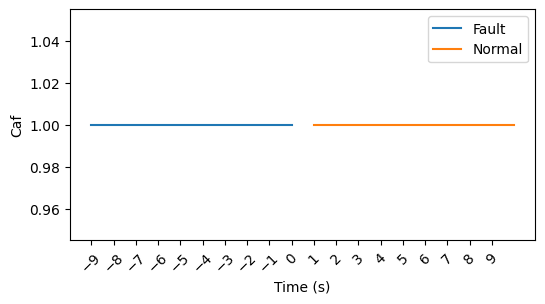

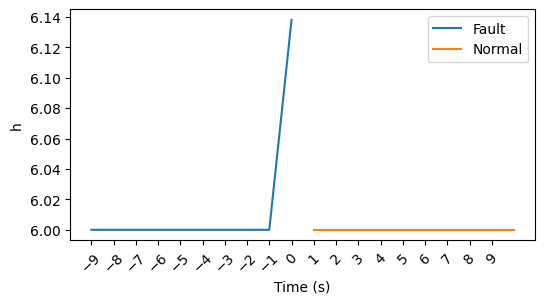

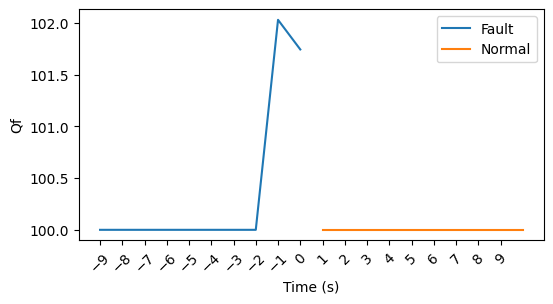

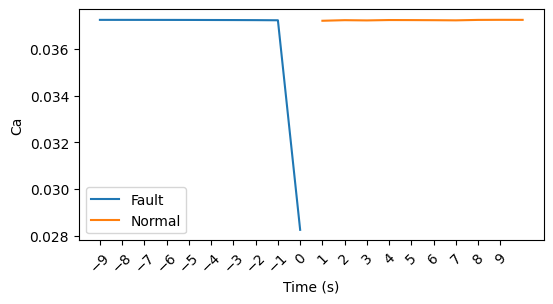

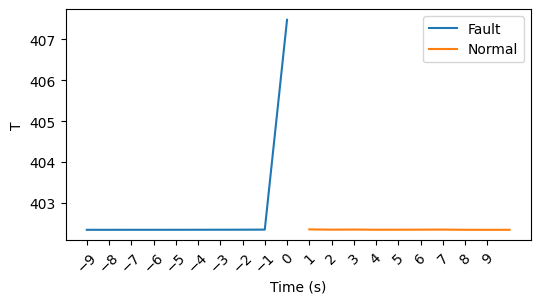

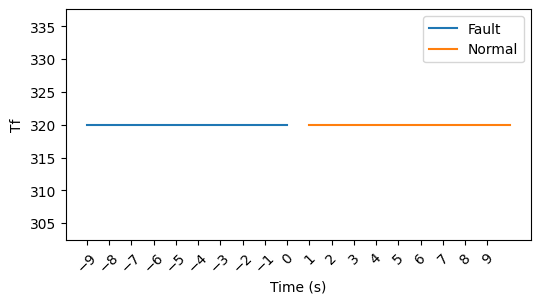

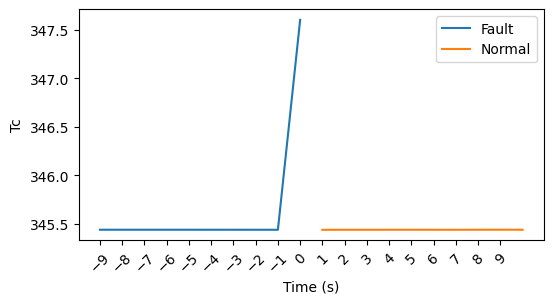

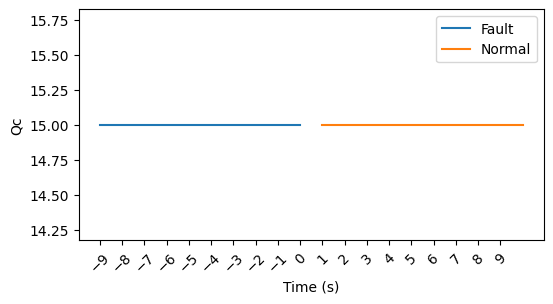

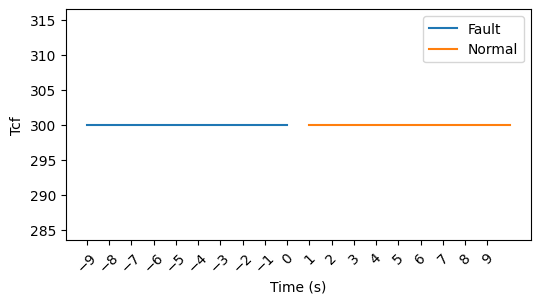

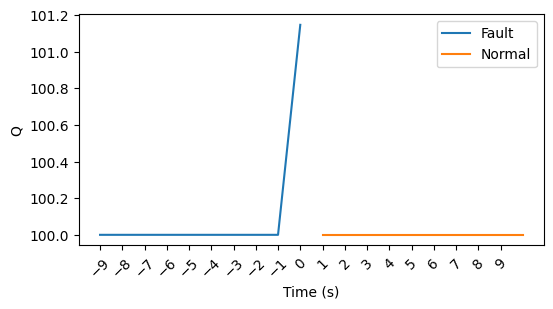

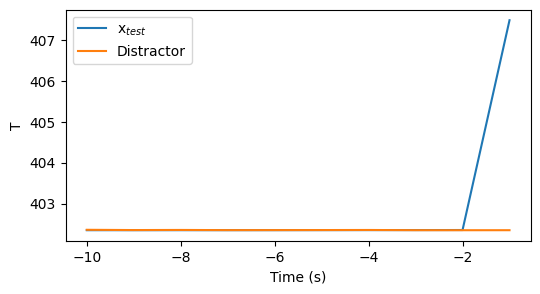

In [35]:
warnings.filterwarnings("ignore")

x_test = test_timeseries.loc[['node_1_31'], :, :]
explanation = comte.explain(x_test,to_maximize=0,savefig=False) 
print('###########') 
print(explanation)
print('###########')

warnings.resetwarnings()